**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark 
- On **Quercus**, submit a ipynb file with your entire code

In [84]:
%%shell
jupyter nbconvert --to html "/content/ECE421_Introduction_to_ML_Fall_2022_Papernot_&_Yaghini_Assignment_5_handout.ipynb"

[NbConvertApp] Converting notebook /content/ECE421_Introduction_to_ML_Fall_2022_Papernot_&_Yaghini_Assignment_5_handout.ipynb to html
[NbConvertApp] Writing 1632807 bytes to /content/ECE421_Introduction_to_ML_Fall_2022_Papernot_&_Yaghini_Assignment_5_handout.html


# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray
import jax

objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 57 kB 2.9 MB/s 


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 43.4MB/s]


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

fit_on_texts will create a dictionary that is indexed by a unique word in one messae and has a value that is its ranking on a list of most frequent words. For example, for a sentence "I am happy today because I saw my friend.". `dict["I"] = 1, dict["am"] = 2`.


**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

It replace each word in each message with its corressponding integer value from the dictionary, which is word to integer map created from fit_on_texts.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

pad_sequence will pad each message with zeros to ensure all message arrays are equal length. By default, it will add the zero the beginning of the array.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

In [ ]:
print(len(messages_train[5]))
print(len(messages_train[4]))

200
200


**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

Yes, it is the length of 200 with integer values. Each message in messages is 200 in length. 

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

__init__  initializes the module that is the embedding layer. The model takes as input an integer matrix of size (input_length/sentence length) and a vector of latent (output dimension). 

__call__ will initialize the call function which will return the values of w.value that have the index described in x.

Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

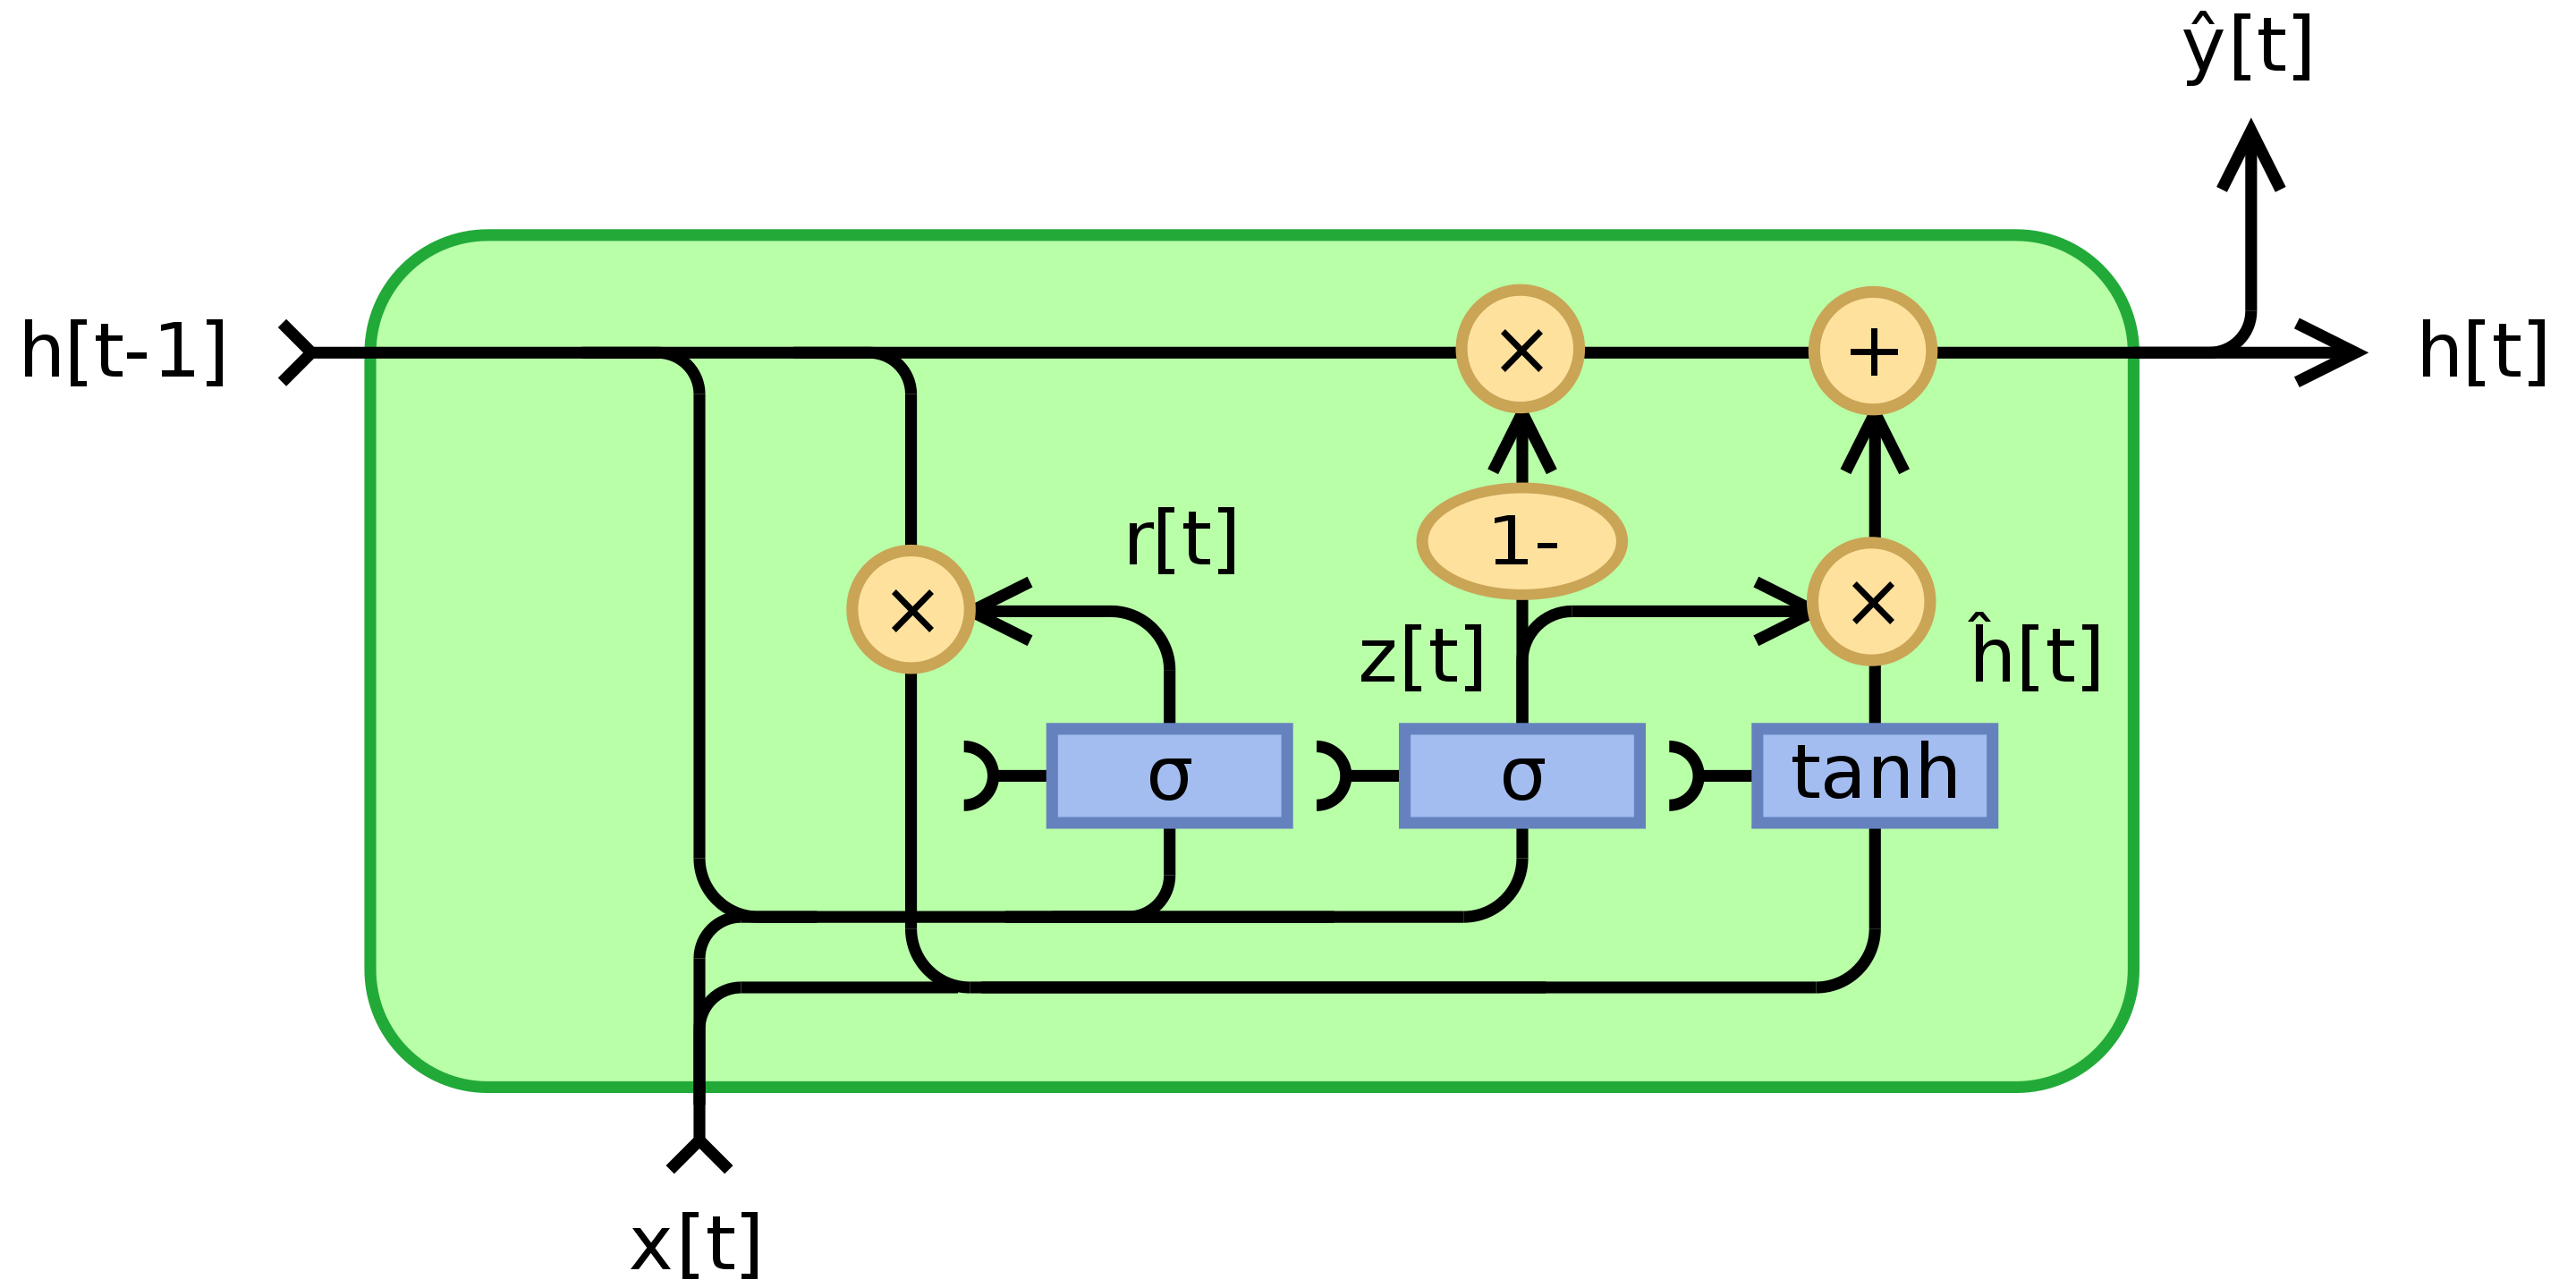

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

- 𝑧𝑡=sigmoid(𝑊𝑧𝑥𝑡+𝑈𝑧ℎ𝑡−1+𝑏𝑧) 
- 𝑟𝑡=sigmoid(𝑊𝑟𝑥𝑡+𝑈𝑟ℎ𝑡−1+𝑏𝑟) 
ℎ̂ 𝑡=tanh(𝑊ℎ𝑥𝑡+𝑈ℎ(𝑟𝑡⊙ℎ𝑡−1)+𝑏ℎ)

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

# 1/(1+np.exp(-z))
    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = 1/ (1+ jn.exp( x @ self.update_w.value + state @ self.update_u.value  + jn.transpose(self.update_b.value) ))

            # fill this in
            reset_gate = 1/ (1+ jn.exp( x @ self.reset_w.value + state @ self.reset_u.value +  jn.transpose(self.reset_b.value) ) )
            
            # fill this in
            output_gate = jn.tanh(  x@self.output_w.value+ state @ self.output_u*reset_gate +  jn.transpose(self.output_b.value) )
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

# GRU(200, 5)

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

- lax.scan essentially replaces a for-loop with carry-over
- the official definition on the JAX documentation says "Scan a function over leading array axes while carrying along state."
- it is an optmized loop which can  speed up compilation and may speed up the code itself
- Using a typically loop would take much longer to compile. To improve this, for lax.scan, JAX scans over the entire function and makes a graph of all the operations that need to be done. 
https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#:~:text=scan,-jax.lax.&text=Scan%20a%20function%20over%20leading%20array%20axes%20while%20carrying%20along%20state.&text=where%20we%20use%20%5Bt%5D%20here,with%20an%20additional%20leading%20axis.

In [ ]:
X_train = messages_train
Y_train = labels_train
X_valid = messages_valid
Y_valid = labels_valid

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([Embed(max_len, embedding_size), 
                               GRU( embedding_size,num_hidden_units_GRU), 
                               objax.functional.relu,
                                objax.nn.Linear(num_hidden_units_GRU, 2)] 
)

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[3](Linear).b            2 (2,)
(Sequential)[3](Linear).w           60 (30, 2)
+Total(12)                       11552


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

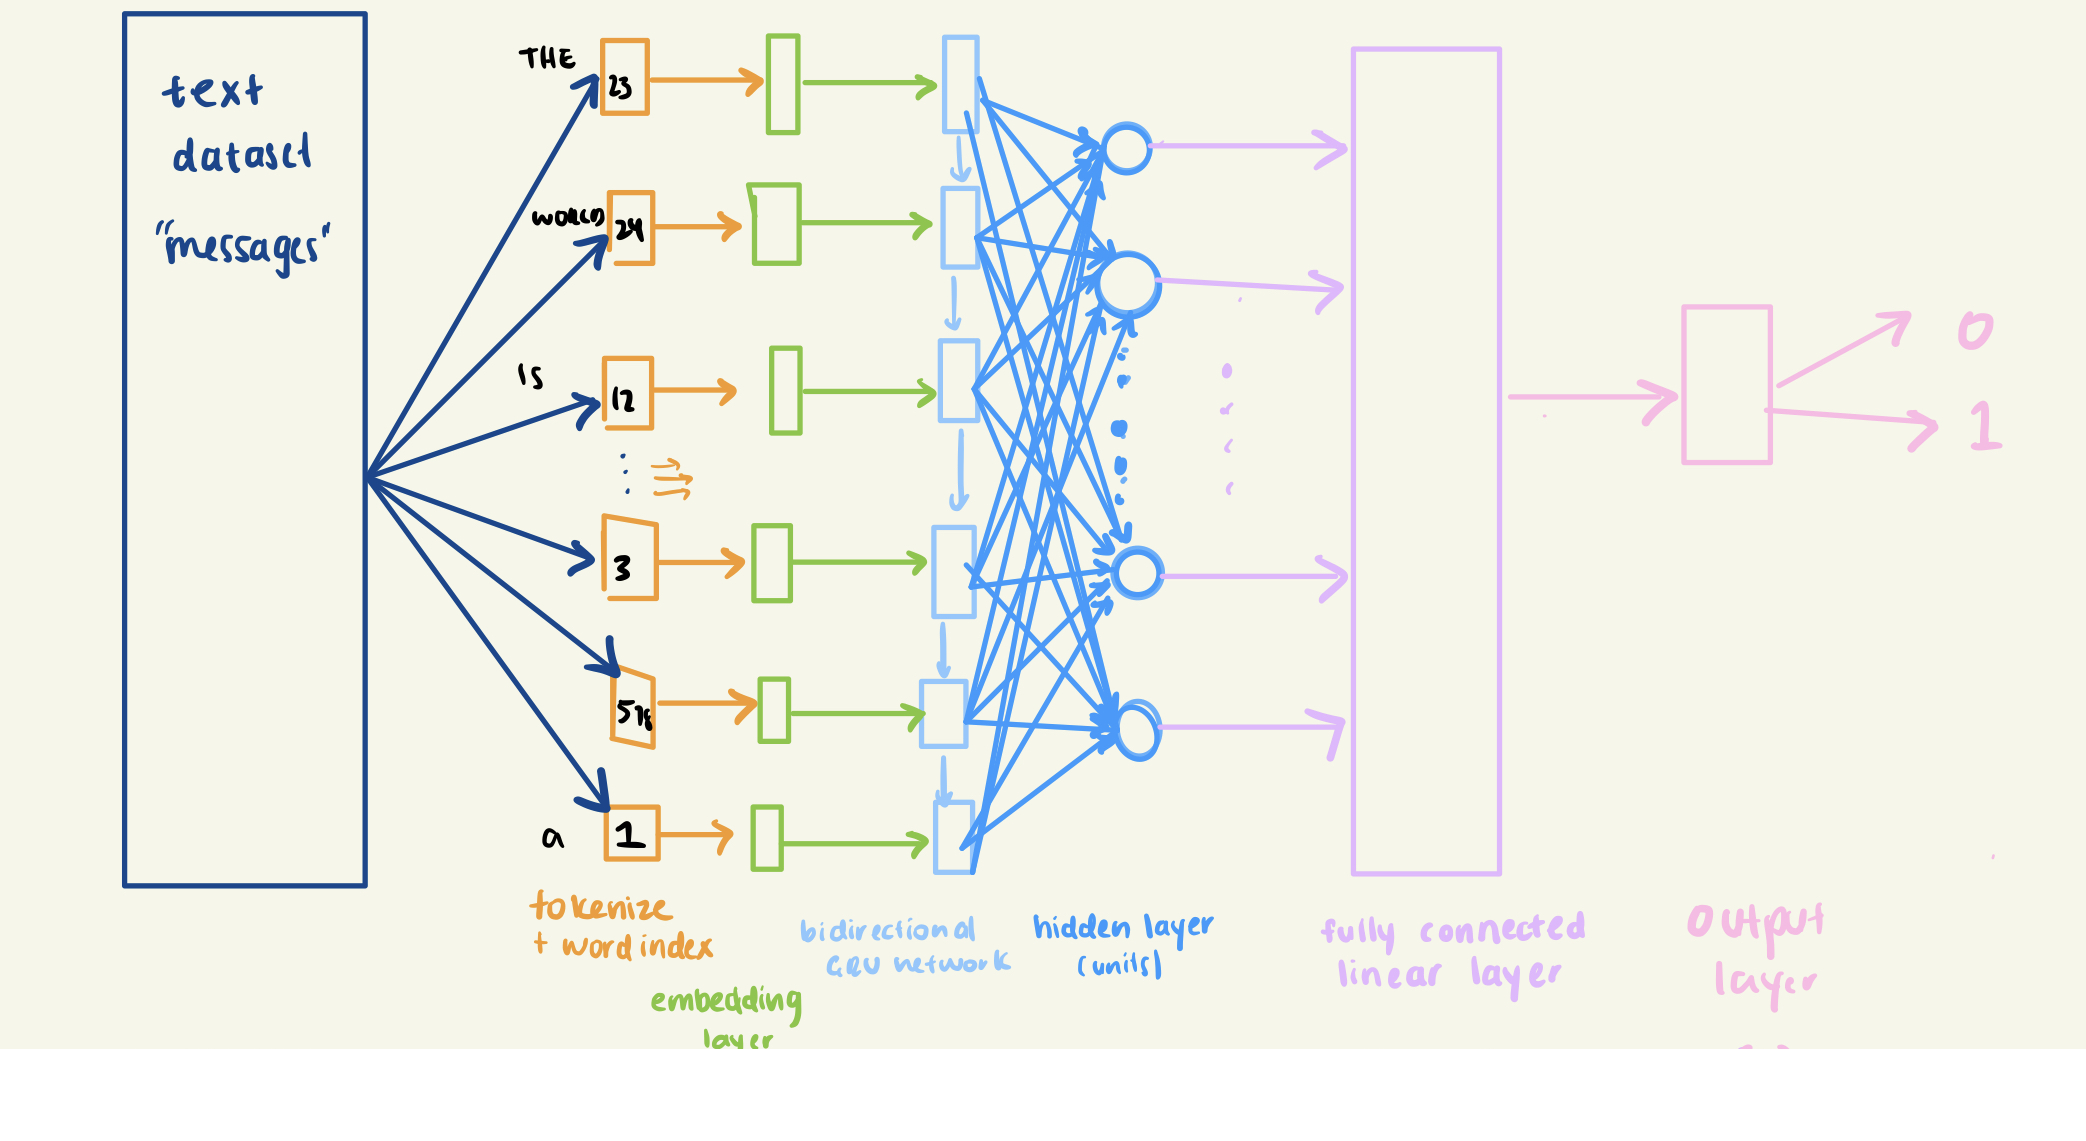

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here

# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

__all__ = ['SGD']

from typing import List

from objax.module import Module, ModuleList
from objax.typing import JaxArray
from objax.util import class_name
from objax.variable import TrainRef, TrainVar, VarCollection


class SGD(Module):
    """Stochastic Gradient Descent (SGD) optimizer."""

    def __init__(self, vc: VarCollection):
        """Constructor for SGD optimizer.

        Args:
            vc: collection of variables to optimize.
        """
        self.train_vars = ModuleList(TrainRef(x) for x in vc.subset(TrainVar))


    def __call__(self, lr: float, grads: List[JaxArray]):
        """Updates variables based on SGD algorithm.

        Args:
            lr: the learning rate.
            grads: the gradients to apply.
        """
        assert len(grads) == len(self.train_vars), 'Expecting as many gradients as trainable variables'
        for g, p in zip(grads, self.train_vars):
            p.value -= lr * g


    def __repr__(self):
        return f'{class_name(self)}()'
opt = SGD(gru_rnn.vars()) # from prev step

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()

gv = objax.GradValues(loss_function, gru_rnn.vars())

@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))), gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 100  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = batch_size, LEARNING_RATE = learning_rate):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(X_train)
        for it in range(0, X_train.shape[0], BATCH):
            batch = train_indices[it:it+BATCH]
            avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            batch = val_indices[it:it+BATCH]
            avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
    
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()


Epoch 0001  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.32 Validation Accuracy 50.80
Epoch 0002  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.46 Validation Accuracy 50.54
Epoch 0003  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.59 Validation Accuracy 50.46
Epoch 0004  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.30 Validation Accuracy 50.54
Epoch 0005  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.54 Validation Accuracy 50.42
Epoch 0006  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.40 Validation Accuracy 50.50
Epoch 0007  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 51.16 Validation Accuracy 50.52
Epoch 0008  Training Loss 69.34 Validation Loss 69.32 Training Accuracy 51.25 Validation Accuracy 50.34
Epoch 0009  Training Loss 69.33 Validation Loss 69.33 Training Accuracy 51.74 Validation Accuracy 50.30
Epoch 0010  Training Loss 69.33 Validation Loss 69.31 Training A

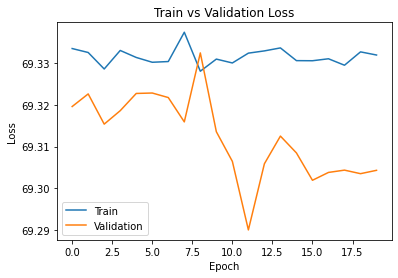

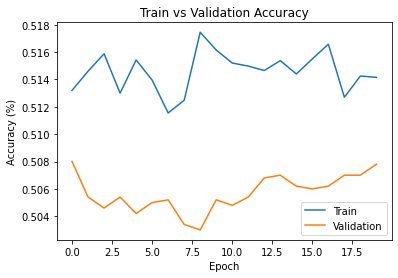

In [ ]:
train()

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

In [ ]:
test_acc = accuracy(test_data)
print(test_acc)

0.50240004


The generalization gap is the difference in the model's perfomance between the training and unseen test test data for the same distribution. 

The value for this example is:
.5141 minus 0.50240004 is 0.0117 => 1.17 %


# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([ Embed(max_len, embedding_size), 
                               GRU(embedding_size,num_hidden_units_GRU), 
                               objax.functional.relu,
                                objax.nn.Linear(num_hidden_units_GRU, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())
predict = objax.Jit(lambda x: objax.functional.softmax(gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))), gru_rnn2.vars())


In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
# your code for the training loop should start here 
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = batch_size, LEARNING_RATE =learning_rate):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(X_train)
        for it in range(0, X_train.shape[0], BATCH):
            batch = train_indices[it:it+BATCH]
            avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            batch = val_indices[it:it+BATCH]
            avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
    
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()



Epoch 0001  Training Loss 69.37 Validation Loss 69.22 Training Accuracy 50.53 Validation Accuracy 51.24
Epoch 0002  Training Loss 69.36 Validation Loss 69.36 Training Accuracy 50.26 Validation Accuracy 49.72
Epoch 0003  Training Loss 69.36 Validation Loss 69.27 Training Accuracy 49.94 Validation Accuracy 52.10
Epoch 0004  Training Loss 69.34 Validation Loss 69.32 Training Accuracy 50.22 Validation Accuracy 49.54
Epoch 0005  Training Loss 69.33 Validation Loss 69.32 Training Accuracy 50.78 Validation Accuracy 51.02
Epoch 0006  Training Loss 69.34 Validation Loss 69.34 Training Accuracy 50.17 Validation Accuracy 49.66
Epoch 0007  Training Loss 69.33 Validation Loss 69.35 Training Accuracy 50.24 Validation Accuracy 48.92
Epoch 0008  Training Loss 69.33 Validation Loss 69.35 Training Accuracy 50.29 Validation Accuracy 48.86
Epoch 0009  Training Loss 69.33 Validation Loss 69.34 Training Accuracy 50.06 Validation Accuracy 48.72
Epoch 0010  Training Loss 69.33 Validation Loss 69.36 Training A

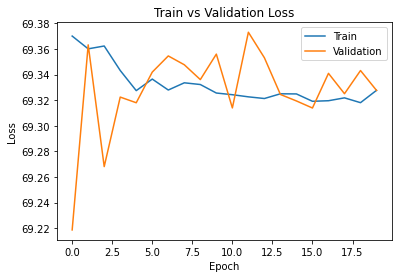

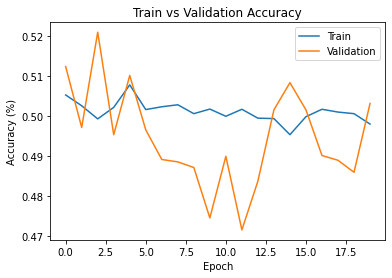

In [ ]:
train()

Epoch 0001  Training Loss 173.37 Validation Loss 173.40 Training Accuracy 50.35 Validation Accuracy 49.00
Epoch 0002  Training Loss 173.37 Validation Loss 173.35 Training Accuracy 50.01 Validation Accuracy 49.18
Epoch 0003  Training Loss 173.36 Validation Loss 173.22 Training Accuracy 50.10 Validation Accuracy 51.04
Epoch 0004  Training Loss 173.31 Validation Loss 173.21 Training Accuracy 50.56 Validation Accuracy 51.12
Epoch 0005  Training Loss 173.36 Validation Loss 173.22 Training Accuracy 50.22 Validation Accuracy 50.82
Epoch 0006  Training Loss 173.32 Validation Loss 173.25 Training Accuracy 50.38 Validation Accuracy 50.80
Epoch 0007  Training Loss 173.30 Validation Loss 173.26 Training Accuracy 50.61 Validation Accuracy 51.02
Epoch 0008  Training Loss 173.32 Validation Loss 173.19 Training Accuracy 50.19 Validation Accuracy 52.10
Epoch 0009  Training Loss 173.32 Validation Loss 173.30 Training Accuracy 50.18 Validation Accuracy 51.62
Epoch 0010  Training Loss 173.33 Validation Lo

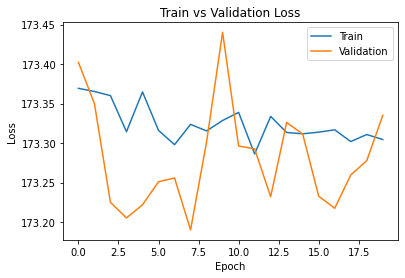

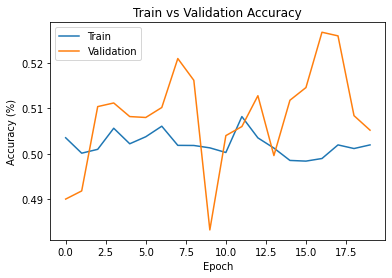

In [ ]:
train()

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [ ]:
print("test accuracy", accuracy(test_data))


test accuracy 0.5138


**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

- The generalization gap is the difference in the model's perfomance between the training and unseen test test data for the same distribution. 
- training + validation accuracy plotted above
- Generalization gap is .5052 imus 0.4902 is 0.015 => 1.5%



**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

SGD will maintain a single learning rate throughout training, whereas the Adam optimizer will update the learning rate for each network weight individually.

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 =  objax.nn.Sequential([ Embed(max_len, embedding_size), 
                               GRU(embedding_size,num_hidden_units_GRU), 
                               objax.functional.relu,
                                objax.nn.Linear(num_hidden_units_GRU, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

predict = objax.Jit(lambda x: objax.functional.softmax(gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))), gru_rnn3.vars())


In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
# your code for the training loop should start here 
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = batch_size, LEARNING_RATE =learning_rate, PATIENCE_WIN =max_patience_window ):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    window_ctr = PATIENCE_WIN;

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch
        improved = False;
        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(X_train)
        
        for it in range(0, X_train.shape[0], BATCH):
            batch = train_indices[it:it+BATCH]
            avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            batch = val_indices[it:it+BATCH]
            avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        print("window_ctr", window_ctr)
        if (window_ctr == 0 and improved == False):
            # stop training
            print("no improvement for ",window_ctr, "epochs. stop training")
            break;
        elif (window_ctr == 0):
            improved = False
            window_ctr = PATIENCE_WIN;
        else:
            window_ctr = window_ctr -1;
            if window_ctr == (max_patience_window-1):
                improved = False
            elif (val_acc_epoch[-1] < val_acc/X_valid.shape[0]):
                print("improved validation accuracy. reset counter to max_patience_window-1!")
                improved = True
                window_ctr = max_patience_window - 1
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
    
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()



As seen above and below

window_ctr 5
Epoch 0001  Training Loss 173.29 Validation Loss 173.35 Training Accuracy 50.02 Validation Accuracy 48.02
window_ctr 4
Epoch 0002  Training Loss 173.29 Validation Loss 173.34 Training Accuracy 50.12 Validation Accuracy 47.56
window_ctr 3
improved validation accuracy. reset counter to max_patience_window-1!
Epoch 0003  Training Loss 173.31 Validation Loss 173.30 Training Accuracy 49.84 Validation Accuracy 47.88
window_ctr 4
improved validation accuracy. reset counter to max_patience_window-1!
Epoch 0004  Training Loss 173.30 Validation Loss 173.28 Training Accuracy 49.92 Validation Accuracy 48.54
window_ctr 4
improved validation accuracy. reset counter to max_patience_window-1!
Epoch 0005  Training Loss 173.30 Validation Loss 173.27 Training Accuracy 49.85 Validation Accuracy 49.16
window_ctr 4
improved validation accuracy. reset counter to max_patience_window-1!
Epoch 0006  Training Loss 173.29 Validation Loss 173.24 Training Accuracy 50.10 Validation Accuracy 52.02
window

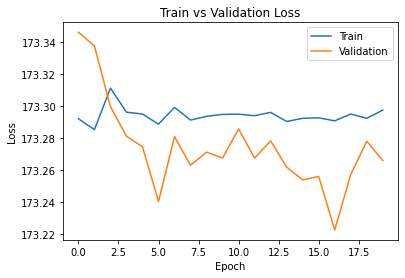

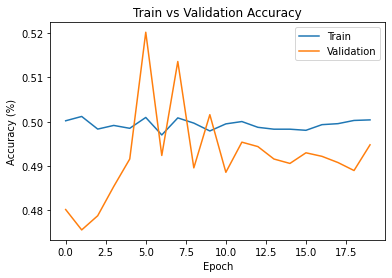

In [ ]:
train()

window_ctr 5
Epoch 0001  Training Loss 173.29 Validation Loss 173.23 Training Accuracy 49.71 Validation Accuracy 49.76
window_ctr 4
Epoch 0002  Training Loss 173.29 Validation Loss 173.18 Training Accuracy 50.23 Validation Accuracy 53.18
window_ctr 4
Epoch 0003  Training Loss 173.30 Validation Loss 173.23 Training Accuracy 50.16 Validation Accuracy 52.84
window_ctr 3
Epoch 0004  Training Loss 173.29 Validation Loss 173.27 Training Accuracy 50.21 Validation Accuracy 49.68
window_ctr 2
Epoch 0005  Training Loss 173.33 Validation Loss 173.30 Training Accuracy 50.30 Validation Accuracy 48.86
window_ctr 1
Epoch 0006  Training Loss 173.29 Validation Loss 173.30 Training Accuracy 50.48 Validation Accuracy 49.26
window_ctr 4
Epoch 0007  Training Loss 173.32 Validation Loss 173.28 Training Accuracy 50.03 Validation Accuracy 49.56
window_ctr 4
Epoch 0008  Training Loss 173.29 Validation Loss 173.27 Training Accuracy 50.16 Validation Accuracy 50.60
window_ctr 4
Epoch 0009  Training Loss 173.29 Va

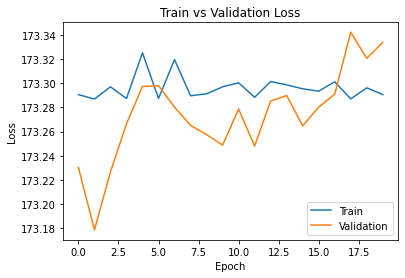

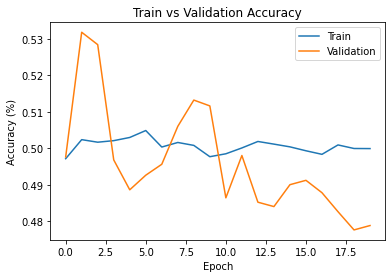

In [ ]:
train()

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [ ]:
print("test accuracy", accuracy(test_data))


test accuracy 0.49140003


**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

- best validation accuracy: 49.48
-test accuracy: 49.140003